In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import time
from collections import OrderedDict
from dtw import dtw
import xml.etree.ElementTree
motion_sensors = [1, 10, 11, 12, 13, 14, 2, 3, 4, 5, 6, 7, 8, 9]
global sensors_list

sensors_list = []

In [82]:
adj_matrix = {"bedroom" : set(['diningroom', 'bathroom']), 
              "bathroom" : set(['diningroom', 'bedroom']),
              "diningroom" : set(['bathroom', 'livingroom', 'bedroom', 'kitchen']),
              "livingroom" : set(['diningroom']),
              "kitchen" : set(['diningroom'])
             }

def smoothListGaussian(list,strippedXs=False,degree=2):  
    window=degree*2-1  
    weight=np.array([1.0]*window)  
    weightGauss=[]  
    for i in range(window):  
        i=i-degree+1  
        frac=i/float(window)  
        gauss=1/(np.exp((4*(frac))**2))  
        weightGauss.append(gauss)  

    weight=np.array(weightGauss)*weight  
    smoothed=[0.0]*(len(list)-window)  
    
    for i in range(len(smoothed)):  
        smoothed[i]=sum(np.array(list[i:i+window])*weight)/sum(weight)  
        if (smoothed[i] < 0.1):
            smoothed[i] = 0
    
    return smoothed      

def room_factor(graph, start, end, path=[]):
    path = path + [start]
    # print(start)
    if start not in graph:     return None
    elif start == end:         return 1
    elif end in graph[start]:  return 2
    else:                      return 3 #4

def FiringSequence(l):
    seq = []
    inds = []
    prev_item = 0
    for i in range(len(l)):
        if (not l[i] == prev_item):
            seq.append(l[i])
            inds.append(i)
            prev_item = l[i]
    return seq, inds
        
def get_sensors_activation_sequence(readings, data_type, df_):
    sensor_seq = []
    for i in range(len(readings)):
        d = ast.literal_eval(readings[i])
        for ind in range(len(d)):
            if (d[ind] == 1):
                t = df_.time[i]
                x = motion_sensors[ind]
                if (x < 9 or x > 12):
                    if (data_type == "synt"):
                        x += 0.2
                    sensor_seq.append((t, x))
    return sensor_seq

def GeoDist(s1, s2):
    if (s1 == -1 or s2 == -1): return 100
    for sensor in sensors_list:
        if int(sensor.sensor_id) == s1:
            sensor1 = sensor
            
    for sensor in sensors_list:
        if int(sensor.sensor_id) == s2:
            sensor2 = sensor
            
    p1 = np.asarray([float(int(sensor1.x) / 100), float(int(sensor1.y) / 100)])
    p2 = np.asarray([float(int(sensor2.x) / 100), float(int(sensor2.y) / 100)])
    # print(np.linalg.norm(p1 - p2))
    # print(room_factor(adj_matrix, sensor1.room, sensor2.room))
    
    return np.linalg.norm(p1 - p2) * room_factor(adj_matrix, sensor1.room, sensor2.room)

def GeoDist2(s1, s2):
    if (s1 == s2): return 0
    else: return 1

def Sequence_analyzer(UltimateDatasetName, session_info):
    global real_sensor_seq
    global synt_sensor_seq
    global synt_indices
    global real_indices
    
    df_ = (pd.read_csv(UltimateDatasetName + ".csv"))
    time_list_formatted = [time.strftime('%H:%M:%S', time.localtime(x)) for x in df_.time]

    print(len(df_))
    real_data = np.asarray(get_sensors_activation_sequence(df_.gt_motion_readings, "real",df_))
    synt_data = np.asarray(get_sensors_activation_sequence(df_.synthetic_motion_readings, "synt", df_))

    # fig = plt.figure()
    fig, ax = plt.subplots(figsize = (10, 7))
    # ax = fig.add_subplot(1, 1, 1)
    plt.scatter(real_data[:,0], real_data[:,1], alpha=0.8, c="b", edgecolors='none', s=30, label="Real-World Dataset")
    plt.scatter(synt_data[:,0], synt_data[:,1], alpha=0.8, c="r", edgecolors='none', s=30, label="Synthetic Dataset")
    # plt.xticks(np.arange(0, len(time_list_formatted), step=20), time_list_formatted[::20])
    ax.set_xticklabels(time_list_formatted[::100])
    plt.yticks(range(1, 15))
    plt.xticks(rotation=90)
    plt.xlabel("time (HH:MM:SS)")
    plt.ylabel("Sensor Number")
    plt.title('Sensors Activation Sequence (' + session_info + ')')
    plt.grid(color='k', linestyle=':', linewidth=0.5)
    plt.legend(loc=1)
    plt.show()
    
    # real_sensor_seq, real_indices = FiringSequence(real_data[:,1])
    # synt_sensor_seq, synt_indices = FiringSequence(list(map(int, synt_data[:,1])))
    
    real_sensor_seq = real_data[:,1]
    synt_sensor_seq = list(map(int, synt_data[:,1]))
    
    
    dist, cost_matrix, acc_cost_matrix, path = dtw(synt_sensor_seq, 
                                                   real_sensor_seq, 
                                                   dist=GeoDist, 
                                                   w = abs(len(real_sensor_seq) - len(synt_sensor_seq)))
                                                   
    max_dist = GeoDist(3, 10) * max(len(real_sensor_seq), len(synt_sensor_seq)) / (len(real_sensor_seq) + len(synt_sensor_seq))
    print(100 - dist/max_dist * 100)

    real_path = []
    for i in path[1]:
        real_path.append(real_sensor_seq[i])
                                                   
    synt_path = []
    for i in path[0]:
        synt_path.append(synt_sensor_seq[i])
                                                   
    plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
    plt.plot(path[0], path[1], 'w')
    plt.show()
    
    # plt.plot(smoothListGaussian(real_sensor_seq))
    plt.plot(real_path)
    plt.show()
    
    # plt.plot(smoothListGaussian(synt_sensor_seq))
    plt.plot(synt_path)
    plt.show()
    
    # print(A)
    # print(B)
    # print(Window_Diff(A, B))

In [70]:
############################################
####      SENSOR CLASSES DEFINITION     ####
############################################

class Sensor:
    sensor_type = ""
    sensor_id = ""
    x = float()
    y = float()
    z = float()
    r = float()
    room = str()

    def __str__(self):
        return 'type: %s,\n id: %s,\n x: %s,\n y: %s\n'%(self.sensor_type, self.sensor_id, self.x, self.y)

    def Initialize(self, element):
        self.x = str(660 - int(str(element.find('point').find('xcoord').text)))
        self.y = (str(element.find('point').find('ycoord').text))
        self.sensor_id = (str(element.find('id').text)).replace('sensor','')
        self.sensor_type = (str(element.find('type').text))     
        return 0
    
    def GaussianFiredSensor(self, simulated_localization, real_localization):
        import math
        sensor_location = [float(self.x)/10, float(self.y)/10]
        cov = [[self.sensing_area, 0],[0, self.sensing_area]]        
        prob = multivariate_normal(simulated_localization, cov)
        probCdf = prob.cdf(sensor_location)
        return probCdf
    
class MotionSensorBinary(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        self.room = (str(element.find('room').text))

In [71]:
############################################
####       PARSE SIMULATION WORLD       ####
############################################

def ParseSimulationWorld(simworldname):
    root = xml.etree.ElementTree.parse(simworldname).getroot()
    global sensors_list
    for element in root:
        if(element.tag == 'sensors'):
            for sensor in element:
                #Choose the kind of sensor we have
                if(str(sensor.find('type').text) == 'RFID_Reader'):
                    # this_sensor = RFID_Reader(sensor)
                    continue

                if(str(sensor.find('type').text) == 'MotionSensorBinary'):
                    # this_sensor = MotionSensorBinary(sensor, radius)
                    this_sensor = MotionSensorBinary(sensor)

                if(str(sensor.find('type').text) == 'MotionSensorAnalog'):
                    this_sensor = MotionSensorAnalog(sensor)

                if(str(sensor.find('type').text) == 'PressureSensorAnalog'):
                    # this_sensor = PressureSensorAnalog(sensor)
                    continue

                if(str(sensor.find('type').text) == 'BeaconSensor'):
                    #this_sensor = BeaconSensor(sensor)
                    continue

                sensors_list.append(this_sensor)

2935


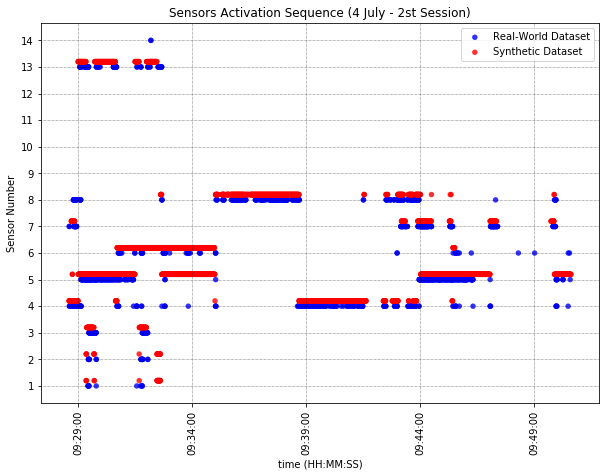

94.93190521954062


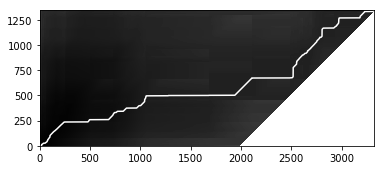

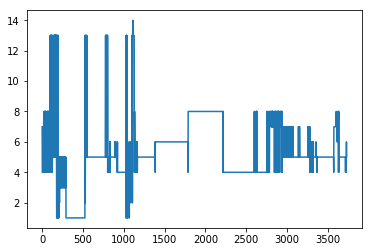

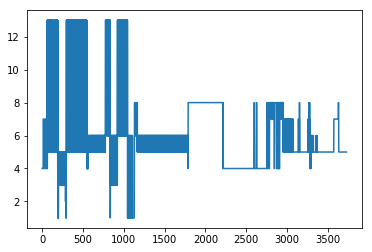

In [72]:
simworldname = 'Data//simulationWorld2.xml'
UltimateDatasetName = "Data//Results//Ultimate_Dataset_4jul1"
ParseSimulationWorld(simworldname)
Sequence_analyzer(UltimateDatasetName, "4 July - 2st Session")

In [73]:
def FindClosestDataPoint(item, reference_list, lower_limit, upper_limit):
    lower_limit = int(lower_limit)
    upper_limit = int(upper_limit )
    ind = lower_limit
    
    diff = GeoDist(int(item), int(reference_list[lower_limit]))
    for i in range(lower_limit, upper_limit):
        new_diff = GeoDist(int(item), int(reference_list[i]))
        if (new_diff < diff):
            diff = new_diff
            ind = i
    reference_list[ind] = -1
    return ind

def SlidingWindowDataMatching(synt_sensor_seq, real_sensor_seq, window_size):
    matching_list = []
    speed = len(synt_sensor_seq) / len(real_sensor_seq)
    j = 0
    for i in range(len(real_sensor_seq)):
        if (j - window_size < 0): lower_limit = 0
        else: lower_limit = j - window_size
        if (j + window_size > len(synt_sensor_seq)): upper_limit = len(synt_sensor_seq)
        else: upper_limit = j + window_size
        ind = FindClosestDataPoint(real_sensor_seq[i], synt_sensor_seq, lower_limit, upper_limit)
        matching_list.append(synt_sensor_seq[ind])
        j = (i+1) * speed
    return matching_list

In [80]:
from sklearn.metrics import mean_squared_error
from math import sqrt

matching_list_dict = {}
rmses = []
max_half_window_size = 500
for window_size in range(1, max_half_window_size + 1):
    matching_list = SlidingWindowDataMatching(synt_sensor_seq, real_sensor_seq, window_size)
    matching_list_dict[window_size] = matching_list
    rmses.append(sqrt(mean_squared_error(real_sensor_seq, matching_list)))
    # plt.plot(matching_list)
    # plt.plot(real_sensor_seq)
    # plt.show()

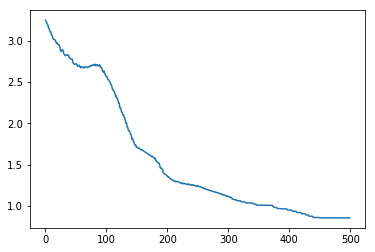

In [81]:
plt.plot(rmses)
plt.show()

In [85]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import recall_score
from math import sqrt

matching_list_dict = {}
recalls = []
max_half_window_size = 500
for window_size in range(1, max_half_window_size + 1):
    if (window_size % 10 == 0):
        print(window_size * 100 / max_half_window_size, ' % completed')
    matching_list = SlidingWindowDataMatching(synt_sensor_seq, real_sensor_seq, window_size)
    matching_list_dict[window_size] = matching_list
    recalls.append(recall_score(real_sensor_seq, matching_list, average='micro'))
    # plt.plot(matching_list)
    # plt.plot(real_sensor_seq)
    # plt.show()

2.0  % completed
4.0  % completed
6.0  % completed
8.0  % completed
10.0  % completed
12.0  % completed
14.0  % completed
16.0  % completed
18.0  % completed
20.0  % completed
22.0  % completed
24.0  % completed
26.0  % completed
28.0  % completed
30.0  % completed
32.0  % completed
34.0  % completed
36.0  % completed
38.0  % completed
40.0  % completed
42.0  % completed
44.0  % completed
46.0  % completed
48.0  % completed
50.0  % completed
52.0  % completed
54.0  % completed
56.0  % completed
58.0  % completed
60.0  % completed
62.0  % completed
64.0  % completed
66.0  % completed
68.0  % completed
70.0  % completed
72.0  % completed
74.0  % completed
76.0  % completed
78.0  % completed
80.0  % completed
82.0  % completed
84.0  % completed
86.0  % completed
88.0  % completed
90.0  % completed
92.0  % completed
94.0  % completed
96.0  % completed
98.0  % completed
100.0  % completed


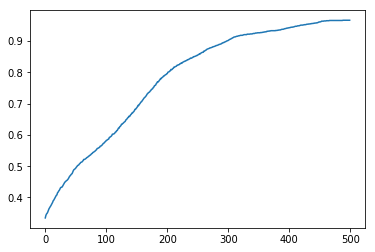

In [86]:
plt.plot(recalls)
plt.show()

In [87]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from math import sqrt

matching_list_dict = {}
precisions = []
max_half_window_size = 500
for window_size in range(1, max_half_window_size + 1):
    if (window_size % 10 == 0):
        print(window_size * 100 / max_half_window_size, ' % completed')
    matching_list = SlidingWindowDataMatching(synt_sensor_seq, real_sensor_seq, window_size)
    matching_list_dict[window_size] = matching_list
    precisions.append(precision_score(real_sensor_seq, matching_list, average='micro'))
    # plt.plot(matching_list)
    # plt.plot(real_sensor_seq)
    # plt.show()

2.0  % completed
4.0  % completed
6.0  % completed
8.0  % completed
10.0  % completed
12.0  % completed
14.0  % completed
16.0  % completed
18.0  % completed
20.0  % completed
22.0  % completed
24.0  % completed
26.0  % completed
28.0  % completed
30.0  % completed
32.0  % completed
34.0  % completed
36.0  % completed
38.0  % completed
40.0  % completed
42.0  % completed
44.0  % completed
46.0  % completed
48.0  % completed
50.0  % completed
52.0  % completed
54.0  % completed
56.0  % completed
58.0  % completed
60.0  % completed
62.0  % completed
64.0  % completed
66.0  % completed
68.0  % completed
70.0  % completed
72.0  % completed
74.0  % completed
76.0  % completed
78.0  % completed
80.0  % completed
82.0  % completed
84.0  % completed
86.0  % completed
88.0  % completed
90.0  % completed
92.0  % completed
94.0  % completed
96.0  % completed
98.0  % completed
100.0  % completed


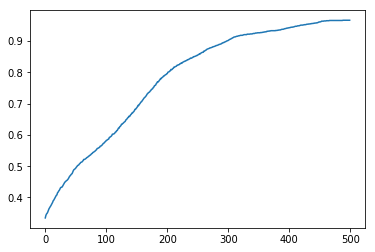

In [88]:
plt.plot(precisions)
plt.show()